In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from torch.autograd import Variable
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data

%matplotlib inline


# Index


[Gather and clean data](#datagather) <br>
[Heatmap of feature correlations](#heatmap) <br>
[Feature Engineering](#features) <br>
[Splitting dataset to train and test](#splitting) <br>
[Machine learning](#ml) <br>
[Recurrent neural network](#neural) <br>
[LSTM](#lstm)



<a id='datagather'></a>

## Gather data and clean data

In [31]:
# Import data
data = pd.read_excel("support_files/OSEBX.xlsx")

In [32]:
data.head()

,OSEBX,Last,High,Low,Official turnover (NOK)
0,2018-11-14,NaN,NaN,NaN,3.790000e+02
1,2018-11-13,875.43,887.95,875.17,5.126725e+09
2,2018-11-12,886.62,892.64,885.44,3.591581e+09
3,2018-11-09,886.44,892.58,884.16,4.405451e+09
4,2018-11-08,892.49,900.74,891.50,4.463838e+09


In [33]:
# Rename some columns to be more descriptive 
data.rename(columns={'OSEBX' : 'Date', 'Official turnover (NOK)' : 'Volume'}, inplace=True)

In [34]:
# Change type to datetime
data['Date'] = pd.to_datetime(data['Date'])

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5743 entries, 0 to 5742
Data columns (total 5 columns):
Date      5743 non-null datetime64[ns]
Last      5742 non-null float64
High      4390 non-null float64
Low       4390 non-null float64
Volume    5624 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 224.4 KB


In [36]:
# Make a target variable that describes if stock market closes up or down next day
data['Direction'] = data.Last.diff().shift()

In [37]:
# Make the direction variable binary
data['Direction'] = data.Direction.apply(lambda x: 1 if x > 0 else 0)

In [38]:
# Alter the last variable to Close on the same line to make it more clear
data['Close'] = data.Last.shift()
data.drop('Last', axis=1, inplace=True)

In [39]:
# Manually set values for the last couple of days
data.set_value(1, 'Close', 876.30)
data.set_value(0, 'Close', 872.10);

C:\anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
C:\anaconda\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


In [40]:
# Reorder columns in a reasonble order
data = data[['Date', 'High', 'Low', 'Close', 'Volume', 'Direction']].copy()

In [41]:
# Sort the timeseries correctly with last observation on the last row (important for technical features)
data = data.sort_values(by='Date', ascending=True);

<a id='features'></a>

## Feature engineering

My dataset only contain Date, High, Low, Close and Volume.
From theese variables I will derive deveral others. Some technical indicators based on Prices and volume such as simple moving averages, RSI, momentum etc. and some derived from the date such as day of week and month

In [42]:
# Moving average indicators, short, medium and long term
data['SMA10'] = data.Close.rolling(10).mean()
data['SMA30'] = data.Close.rolling(30).mean()
data['SMA90'] = data.Close.rolling(90).mean()

In [43]:
# Exponential moving average 
data['EWA10'] = data['Close'].ewm(span=10, min_periods=10).mean()
data['EWA30'] = data['Close'].ewm(span=30, min_periods=30).mean()
data['EWA90'] = data['Close'].ewm(span=90, min_periods=90).mean()

In [44]:
# Stochastic Osciallator
data['SOI'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])

In [45]:
# 10, 5 and 2 Day Momentum
data['Momentum_10'] = data['Close'].diff(10)
data['Momentum_5'] = data['Close'].diff(5)
data['Momentum_2'] = data['Close'].diff(2)

In [46]:
# Standard deviation
data['STD'] = data['Close'].rolling(20, min_periods=20).std()

In [47]:
# Daily variation (High - low)
data['Daily_variation'] = data['High'] - data['Low']

In [48]:
# Day of week
data['Day'] = data.Date.dt.dayofweek

In [49]:
# Month of year
data['Month'] = data.Date.dt.month_name()

In [50]:
# Replace day of week number with string in order to make categorical dummy variables
data['Day'].replace({0: 'Monday', 1 : 'Tuesday', 2: 'Wednesday', 3 : 'Thursday', 4 : 'Friday'}, inplace=True);

In [52]:
# Make dummy variables out of cateorical features 
data = pd.get_dummies(data);

In [53]:
# Reset index
data.reset_index(drop=True, inplace=True);

In [57]:
def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    
    return df

In [58]:
# Add RSI feature
data = relative_strength_index(data, 14)

In [ ]:
# check
data.isnull().sum()

In [78]:
data.tail()

,Date,High,Low,Close,Volume,Direction,SMA10,SMA30,SMA90,EWA10,...,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,RSI_14
5737,2018-11-07,901.70,890.19,892.49,4.601094e+09,1,884.367,899.720667,899.756333,888.598625,...,0,0,0,0,0,0,1,0,0,0.637307
5738,2018-11-08,900.74,891.50,886.44,4.463838e+09,0,886.731,897.993333,899.857444,888.206148,...,0,0,0,0,0,0,1,0,0,0.637307
5739,2018-11-09,892.58,884.16,886.62,4.405451e+09,1,887.815,896.143667,899.834778,887.917757,...,0,0,0,0,0,0,1,0,0,0.501824
5740,2018-11-12,892.64,885.44,875.43,3.591581e+09,0,888.473,893.839333,899.571444,885.647256,...,0,0,0,0,0,0,1,0,0,0.502821
5741,2018-11-13,887.95,875.17,876.30,5.126725e+09,0,887.137,891.706000,899.407667,883.947755,...,0,0,0,0,0,0,1,0,0,0.360389


In [79]:
data.dropna(inplace=True)

In [382]:
# Days with extreme variation --> Outliers
data.Date[data.Daily_variation > 20].count()

AttributeError: 'DataFrame' object has no attribute 'Date'

In [ ]:
data.iloc[data.Daily_variation > 20,:]

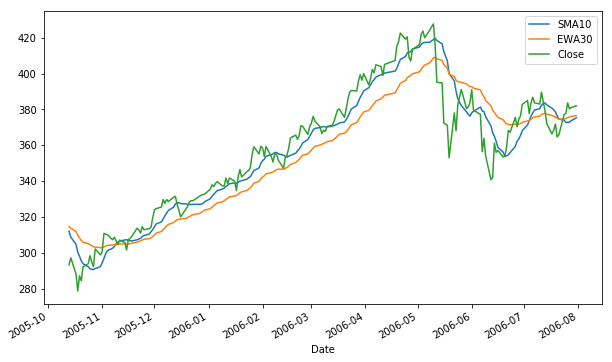

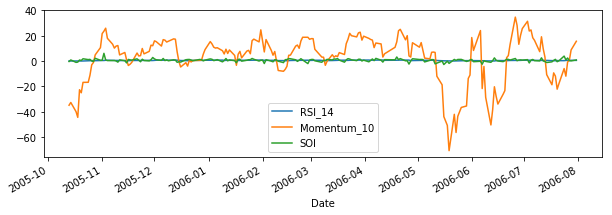

In [380]:
# Visual sanity check of features

f = 1100
t = 1300
data.iloc[f:t].plot( y=['SMA10', 'EWA30', 'Close'], figsize=(10,6));
data.iloc[f:t].plot( y=['RSI_14', 'Momentum_10', 'SOI'], figsize=(10,3));

In [ ]:
plt.boxplot(data.Daily_variation)

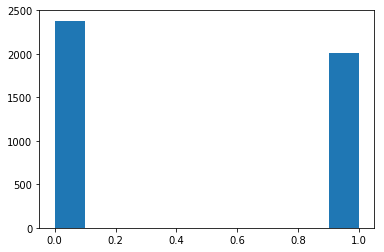

In [87]:
plt.hist(data.Direction);
plt.xlim();
        

In [78]:
# data.reset_index(drop=True, inplace=True)

In [88]:
# Set index to Date
data.set_index('Date', inplace=True)

In [89]:
data.replace(-np.inf, np.nan, inplace=True)

In [90]:
data.fillna(method='ffill', inplace=True)

<a id='heatmap'></a>

## Heatmap of features

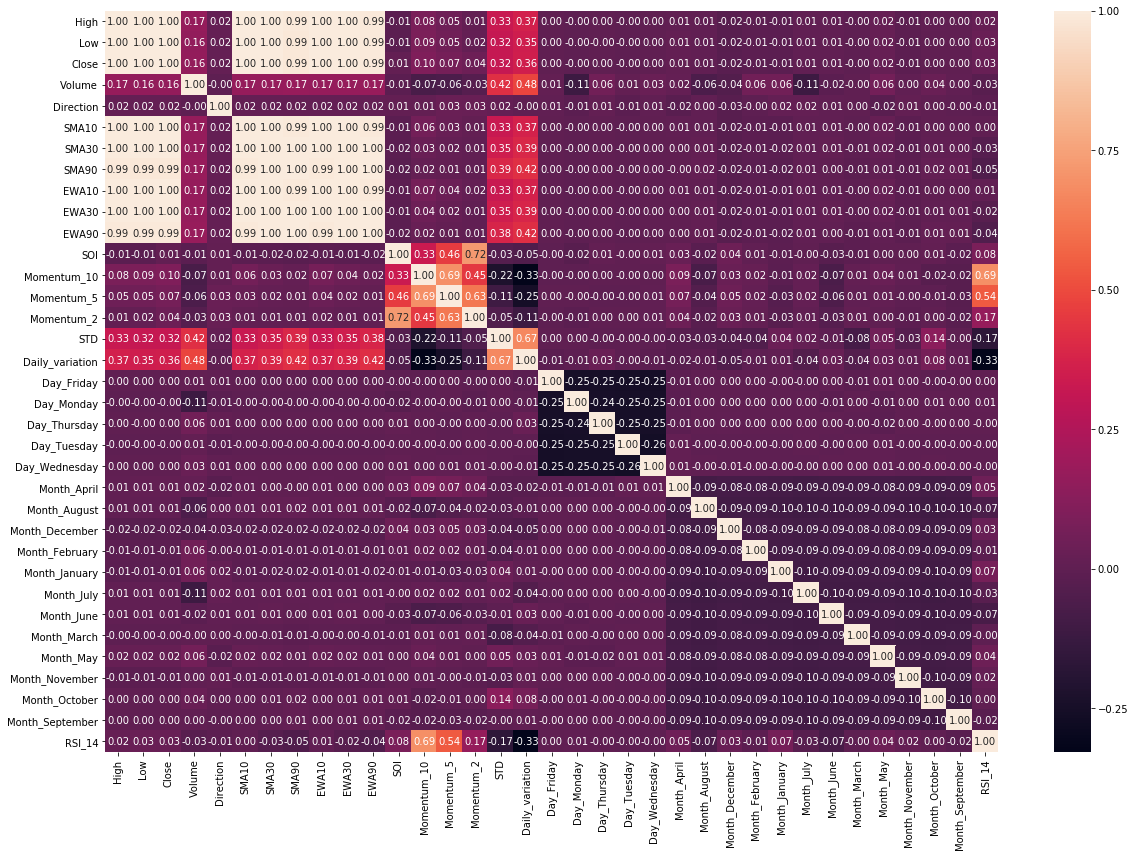

In [381]:
fig, ax = plt.subplots(figsize=(20,30))
plt.subplot(2,1,1)
sns.heatmap(data.corr(), annot=True, fmt='.2f');

<a id='splitting'></a>

## Split data set to train and test set

In [92]:
# Split to target and features
target = data.Direction
features = data.drop(["Direction"], axis=1)

In [93]:
# Normalize the data
norm = MinMaxScaler(feature_range=(0,1))
features = norm.fit_transform(features)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

In [95]:
features.shape

(4388, 34)

In [96]:
features_numpy = data.drop(["Direction"], axis=1).values
target_numpy = data.Direction.values

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(features_numpy, target_numpy, test_size=0.30, random_state=42)


<a id='ml'></a>

## Machine learning

In [97]:
def roc_scores (y_predict, y_test=y_test):
    
    # Compute for probabilities for positive outcome
    fpr, tpr, tresholds = roc_curve(y_test, y_predict[:,1])
    roc_auc = roc_auc_score(y_test, y_predict[:,1])

    return fpr, tpr, tresholds, roc_auc

def plot_roc(fpr, tpr, roc_auc, title="ROC"):
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right");

In [202]:
clf = SVC(probability=True)

param_dist_svm = {
 'kernel': ['linear', 'rbf', 'poly'],
 'C' : [0.001,0.05,0.1]

 }

svmmodel = GridSearchCV(clf, param_grid=param_dist_svm )
svmmodel.fit(X_train, y_train);


In [203]:
y_pred = svmmodel.predict_proba(X_test)


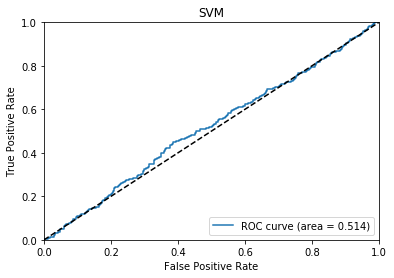

In [204]:
fpr, tpr, tresholds, roc_auc = roc_scores(y_pred)
plot_roc(fpr,tpr,roc_auc, 'SVM')

In [205]:
lr = LogisticRegression()

In [206]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [207]:
y_perd_lr = lr.predict_proba(X_test)

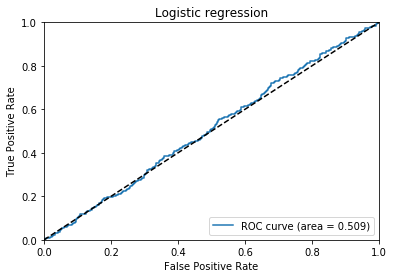

In [208]:
fpr, tpr, tresholds, roc_auc = roc_scores(y_perd_lr)
plot_roc(fpr,tpr,roc_auc, 'Logistic regression')

In [105]:
rf = RandomForestClassifier()

# specify parameters and distributions to sample from
param_dist1 = {"max_depth": [5,10,15,20],
              "n_estimators" : [100, 1000, 10000],
              "min_samples_split": [3,5,10,15,20],
              "bootstrap": [True, False],
              "min_samples_leaf" : [3,5,10,15,20]
                            }
n_iter_search = 20
randommodel = RandomizedSearchCV(rf, param_distributions=param_dist1,
                                   n_iter=n_iter_search, cv=5, verbose=10, n_jobs=-1)
randommodel.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.3min remaining:   20.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.4min finished


In [107]:
rf_pred = randommodel.predict_proba(X_test)

In [109]:
rf_1 = randommodel.predict(X_test)

In [111]:
s = pd.Series(rf_1)

In [209]:
s.value_counts()

0    1126
1     191
dtype: int64

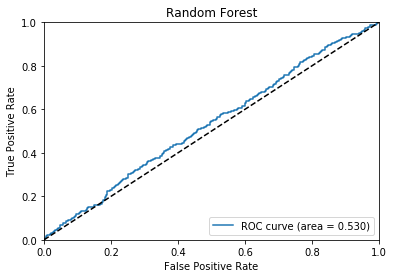

In [108]:
fpr, tpr, tresholds, roc_auc = roc_scores(rf_pred)
plot_roc(fpr,tpr,roc_auc, 'Random Forest')

<a id='neural'></a>

## Recurrent neural network

In [330]:
# Data from numpy
featuresTrain = torch.from_numpy(X_train_np).float()
targetsTrain = torch.from_numpy(y_train_np).float()

featuresTest = torch.from_numpy(X_test_np).float()
targetsTest = torch.from_numpy(y_test_np).float()

In [424]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# Data loader
trainloader = torch.utils.data.DataLoader(train, batch_size = 30, shuffle = False)
testloader = torch.utils.data.DataLoader(test, batch_size = 30, shuffle = False)

In [229]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size

        self.inp = nn.Linear(21, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 2, dropout=0.05)
        
        self.out = nn.Linear(hidden_size, 1)
        self.softmax = nn.LogSoftmax(dim=1)
        

    def step(self, input, hidden=None):
        input = self.inp(input.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        
        output = self.out(output.squeeze(1))
        output = self.softmax(output)
        return output, hidden

    def forward(self, inputs, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 1))
        for i in range(steps):
            if force or i == 0:
                input = torch.tanh(inputs[i])
            else:
                input = torch.tanh(output)
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden
    


In [ ]:
hidden_size = 100
model = SimpleRNN(hidden_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

final_model = train_model(optimizer, criterion, model)



## Rnn

<a id='rnn'></a>

In [350]:
class Model(torch.nn.Module):

    def __init__(self, input_size, rnn_hidden_size, output_size):

        super(Model, self).__init__()

        self.rnn = torch.nn.RNN(input_size, rnn_hidden_size,
                                num_layers=2, nonlinearity='relu',
                                batch_first=True, dropout=0.5)
        
        self.h_0 = self.initialize_hidden(rnn_hidden_size)

        self.linear = torch.nn.Linear(rnn_hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = x.unsqueeze(0)
        self.rnn.flatten_parameters()

        out, self.h_0 = self.rnn(x, self.h_0)
        out = self.linear(out)
        out = self.softmax(out)

        return out

    def initialize_hidden(self, rnn_hidden_size):
        # n_layers * n_directions, batch_size, rnn_hidden_size
        return Variable(torch.randn(2, 1, rnn_hidden_size),
                        requires_grad=True)


<a id='lstm'></a>

In [412]:
class ModelLSTM(torch.nn.Module):

    def __init__(self, hidden_size):

        super(ModelLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.inp = nn.Linear(34, hidden_size)
        
        self.rnn = torch.nn.LSTM(input_size=hidden_size,
                                 hidden_size=hidden_size, 
                                 num_layers=2, 
                                 batch_first=True,
                                 dropout=0.5)
        
        self.out = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def step(self, input, hidden=None):
            input = self.inp(input.view(1, -1)).unsqueeze(1)
            output, hidden = self.rnn(input, hidden)

            output = self.out(output.squeeze(1))
            output = self.softmax(output)
            return output, hidden

    def forward(self, inputs, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 1))
        for i in range(steps):
            if force or i == 0:
                input = inputs[i]
            else:
                input = output
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden

In [413]:
lstmModel = ModelLSTM(100)

In [ ]:
trained_lstm = train_model(optimizer, criterion, lstmModel)

In [ ]:

def stacking_for_charting(given_list):
    ret = np.array([0])
    for i in given_list:
        ret = np.hstack((ret, i.ravel()))
    return ret[1:]

predictions_for_chart = stacking_for_charting(predictions)
correct_values_for_chart = stacking_for_charting(correct_values)

print(predictions_for_chart)

steps = np.linspace(epoch*predictions_for_chart.shape[0],
                    (epoch+1)*predictions_for_chart.shape[0],
                    predictions_for_chart.shape[0])
plt.plot(steps, predictions_for_chart, 'r-')
plt.plot(steps, correct_values_for_chart, 'b-')
plt.draw()
plt.pause(0.05)


In [437]:

def train(model, input_size, hidden_size, output_size, train_loader):
    plt.figure(1, figsize=(12, 5))
    running_loss = 0
    running = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    predictions = []
    correct_values = []
    epochs = 50
    steps = 0
    print_every = 200

    for epoch in range(epochs):
        model.train()
        

        for inp, label in train_loader:
            steps += 1
            inp, label = Variable(inp), Variable(label)

            y_pred = model.forward(inp)
                    
            loss = criterion(y_pred[0].reshape(-1), label)
            
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
            running_loss += loss.item()
            
            # For visualizing
            running.append(running_loss)
            
            if steps % print_every == 0:
                accuracy = (y_pred[0].reshape(-1).data.numpy() == label.data.numpy()).sum() *100 / len(label)
                print("Epoch : {}/{}, running_loss : {} , Accuracy : {} %".format(epoch, epochs, running_loss, accuracy))

            predictions.append(y_pred.cpu().data.numpy().ravel())
            correct_values.append(label.cpu().data.numpy().ravel())
            
            
            running_loss = 0
            
            

    
    
    return model, running, predictions, correct

In [344]:
model = Model(input_size=34, rnn_hidden_size=32, output_size=1)

In [345]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

trained, running, preds = train(model, 34, 100, 1, trainloader)

Epoch : 0/1, running_loss : 0.1428571492433548 , Accuracy : 85.71428571428571 %
Epoch : 0/1, running_loss : 0.5714285969734192 , Accuracy : 42.857142857142854 %
Epoch : 0/1, running_loss : 0.4285714328289032 , Accuracy : 57.142857142857146 %
Epoch : 0/1, running_loss : 0.4285714328289032 , Accuracy : 57.142857142857146 %
Epoch : 0/1, running_loss : 0.0 , Accuracy : 100.0 %
Epoch : 0/1, running_loss : 0.2857142984867096 , Accuracy : 71.42857142857143 %
Epoch : 0/1, running_loss : 0.4285714328289032 , Accuracy : 57.142857142857146 %
Epoch : 0/1, running_loss : 0.4285714328289032 , Accuracy : 57.142857142857146 %


<Figure size 864x360 with 0 Axes>

In [426]:
trained, running, preds = train(lstmModel, 34, 100, 1, trainloader)

Epoch : 1/50, running_loss : 0.7666666507720947 , Accuracy : 23.333333333333332 %
Epoch : 3/50, running_loss : 0.5 , Accuracy : 50.0 %
Epoch : 5/50, running_loss : 0.6333333253860474 , Accuracy : 36.666666666666664 %
Epoch : 7/50, running_loss : 0.4000000059604645 , Accuracy : 60.0 %
Epoch : 9/50, running_loss : 0.4333333373069763 , Accuracy : 56.666666666666664 %
Epoch : 11/50, running_loss : 0.699999988079071 , Accuracy : 30.0 %
Epoch : 13/50, running_loss : 0.5 , Accuracy : 50.0 %
Epoch : 15/50, running_loss : 0.30000001192092896 , Accuracy : 70.0 %
Epoch : 17/50, running_loss : 0.5 , Accuracy : 50.0 %
Epoch : 19/50, running_loss : 0.5666666626930237 , Accuracy : 43.333333333333336 %
Epoch : 21/50, running_loss : 0.7333333492279053 , Accuracy : 26.666666666666668 %
Epoch : 23/50, running_loss : 0.5666666626930237 , Accuracy : 43.333333333333336 %
Epoch : 25/50, running_loss : 0.4333333373069763 , Accuracy : 56.666666666666664 %
Epoch : 27/50, running_loss : 0.6000000238418579 , Accu

<Figure size 864x360 with 0 Axes>

In [ ]:
accuracy_test(trained, testloader)

In [419]:
def accuracy_test(model, loader=testloader):    
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for inp, labels in loader:
            
            inp, labels = Variable(inp), Variable(labels)

            outputs = model(inp)
           
            total += labels.size(0)
            correct += (outputs[0].reshape(-1) == labels).sum()
            print(outputs[0].reshape(-1).data)
            

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    

In [359]:
accuracy_test(trained, testloader)

Accuracy of the network on the test images: 54 %


In [385]:
y_pred_rnn = trained.


<bound method Module.parameters of Model(
  (rnn): RNN(34, 32, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (softmax): Softmax()
)>

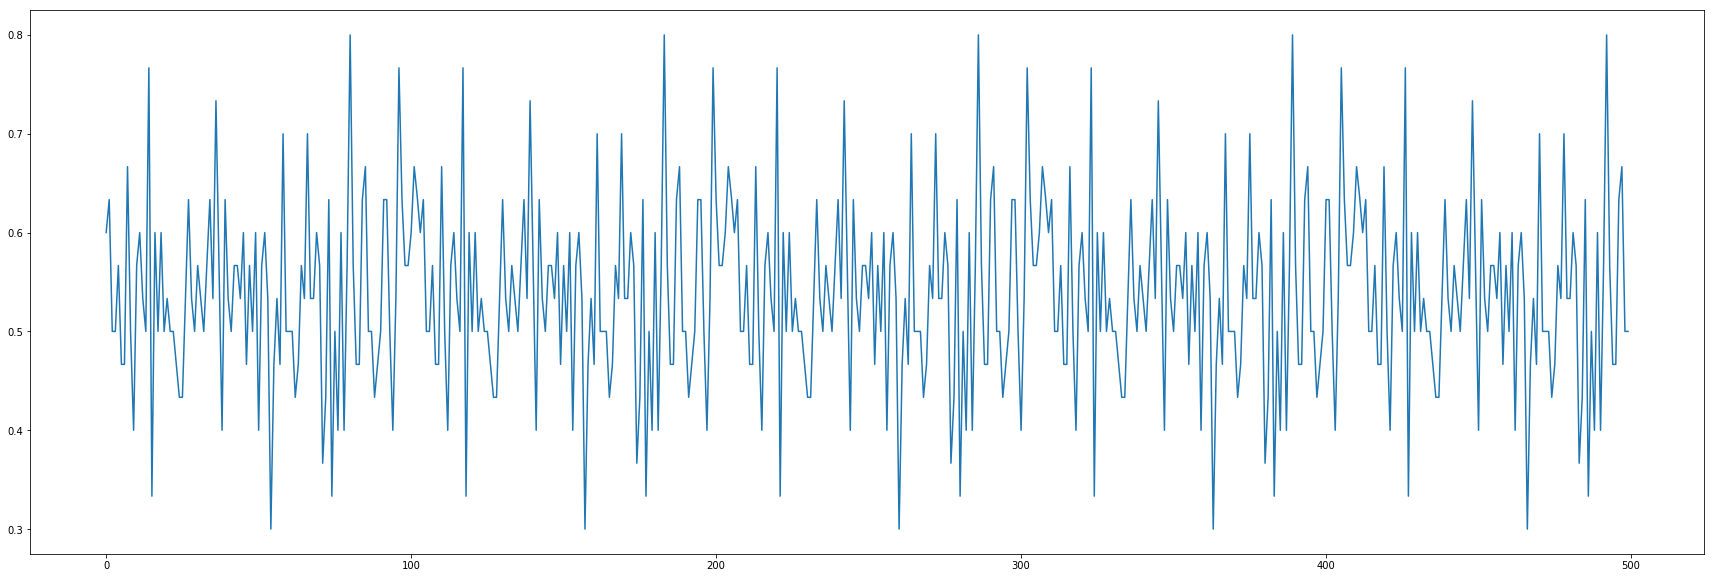

In [435]:
plt.subplots(figsize=(30,10))
plt.plot(running[:500]);

In [436]:
preds

[]

In [353]:
def save_checkpoint(model):

    checkpoint = {
                  'hidden_size' : 32,        
                  'input_size' : 34,
                  'output_size' : 1,
                  'optimizer' : optimizer.state_dict,
                  'state_dict' :  model.state_dict()              
    
                 }
    
    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(trained)

In [355]:
def load_checkpoint(filepath):
    """
    Loads checkpoint of model. Takes filepath as input and returns loaded model.
    """
    checkpoint = torch.load(filepath)
    
    hidden_size = checkpoint['hidden_size']
    input_size = checkpoint['input_size']
    output_size = checkpoint['output_size']
    
    model = Model(input_size, hidden_size, output_size)
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

loaded_model = load_checkpoint('checkpoint.pth')

In [360]:
accuracy_test(loaded_model, testloader)

Accuracy of the network on the test images: 54 %
